In [2]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
constant_val = 27
np.random.seed(constant_val)
random.seed(constant_val)
tf.random.set_seed(constant_val)

## **Step 1: Visualize the Video with its Labels**

In [4]:
DATASET_DIR='Vedios'

In [5]:
classes_names = os.listdir(DATASET_DIR)
classes_names

['NonViolence', 'Violence']

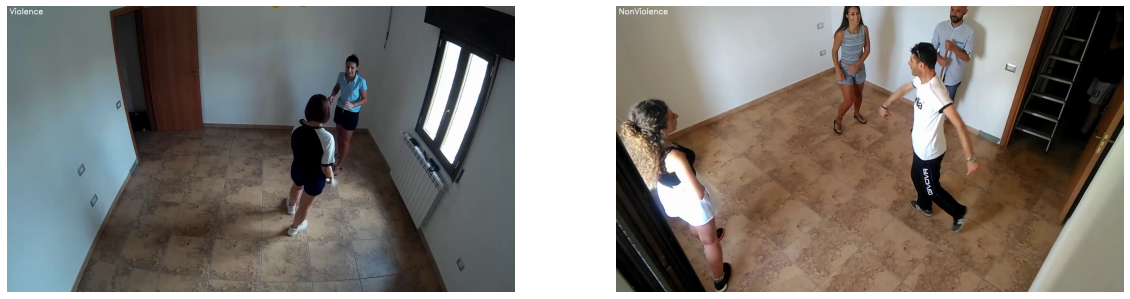

In [6]:
#visualize video's  random frame 
plt.figure(figsize = (20, 20))

classes_names = os.listdir(DATASET_DIR)

random_range = random.sample(range(len(classes_names)),2) 

for counter, random_index in enumerate(random_range, 1):
 
    selected_class_Name = classes_names[random_index]
 
    video_names_list = os.listdir(f'{DATASET_DIR}/{selected_class_Name}')
 
    selected_video = random.choice(video_names_list)
    
    video_reader = cv2.VideoCapture(f'{DATASET_DIR}/{selected_class_Name}/{selected_video}')
   
    _,frame = video_reader.read()
 
    video_reader.release()
 
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
 
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    plt.subplot(1, 2, counter);plt.imshow(rgb_frame);plt.axis('off')

## **Step 2: Preprocess the Dataset**

In [7]:
#define the some constat value
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 25
DATASET_DIR = 'Vedios'
CLASSES_LIST = ['NonViolence', 'Violence']

Note: The IMAGE_HEIGHT, IMAGE_WIDTH and SEQUENCE_LENGTH constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.

## **Extract, Resize & Normalize  Video Frames**

In [8]:
def video_frames_extraction(video_path):
   
    # list to store video frames.
    video_frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter_value in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter_value * skip_frames_window)
        check, frame = video_reader.read() 
        if not check:
            break
            
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        video_frames_list.append(normalized_frame)
    

    video_reader.release()
    return video_frames_list

## **Create a Function for Dataset Creation**

Now we will create a function create_dataset() that will iterate through all the classes specified in the CLASSES_LIST constant and will call the function frame_extraction() on every video file of the selected classes and return the frames (features), class index ( labels), and video file path (video_files_paths).

In [9]:
def dataset_creation():
   
    # Declared Empty Lists to store the features, labels 
    video_features = []
    video_labels = []
    
    # Iterating through classes 
    for class_id, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = video_frames_extractio(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            if len(frames) == SEQUENCE_LENGTH:
                video_features.append(frames)
                video_labels.append(class_id)
 
    video_features = np.asarray(features)
    video_labels = np.array(labels)  
   
    return video_features, video_labels

Now we will utilize the function create_dataset() created above to extract the data of the selected classes and create the required dataset.

In [10]:
# Create the dataset.
video_features, video_labels = dataset_creation()

Extracting Data of Class: NonViolence


KeyboardInterrupt: 

Now we will convert labels (class indexes) into one-hot encoded vectors.

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
encoded_labels = to_categorical(video_labels)

NameError: ignored

# **Step 3: Split the Data**

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(video_features, encoded_labels, test_size = 0.25, shuffle = True, random_state = constant_val)


# **Step 4: Implement the LRCN Approach**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video.

But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

## **Step 4.1: Construct the Model**



In [ ]:

def LRCN_model_create():
    
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'sigmoid'))

    model.summary()
 
    return model


In [ ]:

LRCN_model = LRCN_model_create()


###  **Step 4.2: Compile & Train the Model**

After checking the structure, we will compile and start training the model.

In [ ]:

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = tf.losses.BinaryCrossentropy(), optimizer = 'adam', metrics = ["accuracy"])
 
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


### **Evaluating the trained Model**

As done for the previous one, we will evaluate the LRCN model on the test set.

In [ ]:
# Evaluate the trained model.
evaluation_history = LRCN_model.evaluate(features_test, labels_test)


## **Save the Model**

After that, we will save the model for future uses using the standered way.

In [ ]:

# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)


## **Step 4.3: Plot Model’s Loss & Accuracy Curves**

Now we will utilize the function plot_metric() we had created above to visualize the training and validation metrics of this model.

In [ ]:

def plot_Graphs(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()


In [ ]:

# Visualize the training and validation loss metrices.
plot_Graphs(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


In [ ]:

# Visualize the training and validation accuracy metrices.
plot_Graphs(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


### **Create a Function For Predict Videos**


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:

def video_prediction(video_file_path, output_file_path, SEQUENCE_LENGTH):
  
    video_reader = cv2.VideoCapture(video_file_path)
 
    video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (video_width,video_height))
 
    video_frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
        ok, frame = video_reader.read() 
     
        if not ok:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        video_frames_queue.append(normalized_frame)
 
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(video_frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
     
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)
        cv2_imshow(frame)

    video_reader.release()
    video_writer.release()


### **Create a Function To Perform a Single Prediction on Videos**


In [ ]:

def predict_single_action_inVideo(video_file_path, SEQUENCE_LENGTH):
   
    video_reader = cv2.VideoCapture(video_file_path)
    video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    frames_list = []
   
    predicted_class_name = ''
 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 

        if not success:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model 
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()
